# Salt segmentation

In this fifth lab of the **ErSE 222 - Machine Learning in Geoscience** course, we will implement a Convolutional Neural Network that can segment seismic data and extract salt bodies. For this example we will use the openly available dataset from the [TGS Kaggle Competition](https://www.kaggle.com/c/tgs-salt-identification-challenge).

More specifically, this notebook is organized as follows:

- Load dataset from a collection of .png images as provided in the Kaggle competition. For this we will rely on the `Dataset` module in Torch
- Perform a number of data augumentation stategies such as De-meaning or Polarity flipping
- Train a UNet to segment the images in binary masks (0: no salt, 1: salt)

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchvision 

from scipy.signal import filtfilt
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import accuracy_score, f1_score
from skimage import io
from tqdm.notebook import tqdm

from torch.utils.data import TensorDataset, DataLoader, Dataset, ConcatDataset
from torchvision.utils import make_grid
from torchvision import transforms
from torchsummary import summary

from utils import *
from dataset import *
from model import *
from train import *

In [2]:
set_seed(0)

True

Let's begin by checking we have access to a GPU and tell Torch we would like to use it:

In [3]:
device = 'cpu'
if torch.cuda.device_count() > 0 and torch.cuda.is_available():
    print("Cuda installed! Running on GPU!")
    device = torch.device(torch.cuda.current_device())
    print(f'Device: {device} {torch.cuda.get_device_name(device)}')
else:
    print("No GPU available!")

Cuda installed! Running on GPU!
Device: cuda:0 Tesla V100-SXM2-32GB


## Data loading

Let's start by loading the dataset, which is composed by pairs of images and masks. We are going to define a custom `Dataset` (see https://pytorch.org/tutorials/beginner/data_loading_tutorial.html) as well as apply some transformations (see https://pytorch.org/vision/stable/transforms.html).

In [4]:
# Define paths for folders containing images and masks
datapath = './data'
validperc = 0.2 # percentage of validation samples

traindatapath = os.path.join(datapath, 'train', 'images')
trainmaskpath = os.path.join(datapath, 'train', 'masks')
trainfiles = os.listdir(traindatapath)

nimages = len(trainfiles)
trainfiles = trainfiles[:int((1-validperc) * nimages)]
validfiles = os.listdir(trainmaskpath)[int((1-validperc) * nimages):]

# Define data loading strategy for images
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Resize((128, 128)),
                                DeMean()
                               ])

# Define data loading strategy for masks
transformmask = transforms.Compose([transforms.ToTensor(),
                                    transforms.Resize((128, 128)),
                                    Binarize()
                                   ])

# Create Train Dataset
train_dataset = SaltDataset(traindatapath, trainmaskpath, trainfiles, 
                            transform=transform, transformmask=transformmask)
print('Training samples:', len(train_dataset))

# Create Test Dataset
valid_dataset = SaltDataset(traindatapath, trainmaskpath, validfiles, 
                            transform=transform, transformmask=transformmask)
print('Validation samples:', len(valid_dataset))

Training samples: 3200
Validation samples: 800


## Data augumentation

We can also try to augument our dataset. One simple idea is to just flip the images horizontally and concatenate the two datasets

In [5]:
augument = False
if augument:
    transformaugment = transforms.Compose([transforms.ToTensor(), 
                                           transforms.Resize((128, 128)),
                                           DeMean(),
                                           transforms.RandomHorizontalFlip(p=1)
                                           ])
    transformmaskaugument = transforms.Compose([transforms.ToTensor(),
                                                transforms.Resize((128, 128)),
                                                Binarize(),
                                                transforms.RandomHorizontalFlip(p=1)
                                               ])
    train_dataset = \
        ConcatDataset([SaltDataset(traindatapath, trainmaskpath, trainfiles, transform=transform, transformmask=transformmask),
                       SaltDataset(traindatapath, trainmaskpath, trainfiles, transform=transformaugment, transformmask=transformmaskaugument)])
    print('Training samples:', len(train_dataset))

    valid_dataset = \
        ConcatDataset([SaltDataset(traindatapath, trainmaskpath, validfiles, transform=transform, transformmask=transformmask),
                       SaltDataset(traindatapath, trainmaskpath, validfiles, transform=transformaugment, transformmask=transformmaskaugument)])
    print('Validation samples:', len(valid_dataset))

## Visualize dataset

We are now ready to visualize out dataset

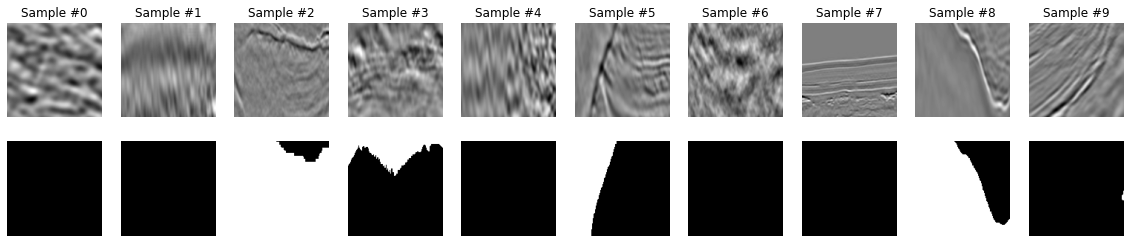

In [6]:
ncols = 10

fig, axs = plt.subplots(2, ncols, figsize=(20, 4))
for i in range(ncols):
    image, mask = train_dataset[i]['image'][0], train_dataset[i]['mask'][0]
    axs[0, i].imshow(image, cmap='gray', vmin=-1, vmax=1)
    axs[0, i].set_title('Sample #{}'.format(i))
    axs[0, i].axis('off')
    axs[1, i].imshow(mask, cmap='gray')
    axs[1, i].axis('off')

if augument:
    # Horizonally flipped data
    fig, axs = plt.subplots(2, ncols, figsize=(20, 4))
    for i in range(ncols):
        image, mask = train_dataset[len(train_dataset)//2+i]['image'][0], train_dataset[len(train_dataset)//2+i]['mask'][0]
        axs[0, i].imshow(image, cmap='gray', vmin=-1, vmax=1)
        axs[0, i].set_title('Sample #{}'.format(i))
        axs[0, i].axis('off')
        axs[1, i].imshow(mask, cmap='gray')
        axs[1, i].axis('off')


We can immediately see some problems with the masks provided in the TGS dataset. For example for sample 5, it is not obvious to see the correct shape of the salt body in the mask. Let's keep this in mind, we will come back to it later in the notebook.

We can now create our dataloaders.

In [7]:
batch_size=64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False) 
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False) 

Finally we want to find out the percentage of non-salt vs. salt pixels so that we can weight this in the loss function

In [8]:
npixels = 0
npos = 0
for dl in tqdm(train_loader):
    y = dl['mask']
    npixels += len(y.view(-1))
    npos += int(y.view(-1).sum())
scaling = np.round((npixels-npos)/npos)
print(scaling)

  0%|          | 0/50 [00:00<?, ?it/s]

3.0


Using this number we can define a baseline accuracy in the case we always predict 1 or 0 to see if by training a network we can indeed do better than just guessing always one of the solutions

In [9]:
accuracy_neg = scaling/(scaling+1)
accuracy_pos = 1/(scaling+1)

print('Accuracy allneg', accuracy_neg)
print('Accuracy allpos', accuracy_pos)

Accuracy allneg 0.75
Accuracy allpos 0.25


We need at least to produce better scores that 0.75, otherwise we are just doing worse than saying there is no salt whatsoever!

## UNet Architecture

We are now ready to create our UNet Architecture. This code is highly inspired from the [Coursera GAN Specialization](https://www.coursera.org/specializations/generative-adversarial-networks-gans?utm_source=gg&utm_medium=sem&utm_content=01-CatalogDSA-ML1-US&campaignid=12490862811&adgroupid=119269357576&device=c&keyword=&matchtype=b&network=g&devicemodel=&adpostion=&creativeid=503940597773&hide_mobile_promo&gclid=EAIaIQobChMIlMrejc668gIVjtd3Ch3GPwOMEAAYASAAEgJYyvD_BwE) UNet tutorial. 

We apply some modifications, especially to allow choosing the depth of the contracting and expanding paths.

In [10]:
set_seed(42)
network = UNet(1, 1, hidden_channels=16, levels=4).to(device)
#network = network.apply(weights_init) 
print(network)
#summary(network, input_size=(1, 128, 128)) # does not work if you have more than one GPU and want to use the non-default one

UNet(
  (upfeature): FeatureMapBlock(
    (conv): Conv2d(1, 16, kernel_size=(1, 1), stride=(1, 1))
  )
  (contracts): Sequential(
    (0): ContractingBlock(
      (conv1): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (activation): LeakyReLU(negative_slope=0.2)
      (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (batchnorm): BatchNorm2d(32, eps=1e-05, momentum=0.8, affine=True, track_running_stats=True)
    )
    (1): ContractingBlock(
      (conv1): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (activation): LeakyReLU(negative_slope=0.2)
      (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (batchnorm): BatchNorm2d(64, eps=1e-05, momentum=0.8, affine=True, track_running_stats=True)
    

**Exercise**: You can see that we have so far commented out the initialization of weights, meaning we use the default initialization in PyTorch. Try playing with different iniliazation strategies and see how that affects the result. Remember our previous lab when we used the W&B tool, do not start doing wild experimentation without tracking your results, leverage this tool when it makes sense!

## Training

Let's train!!

  0%|          | 0/50 [00:00<?, ?it/s]

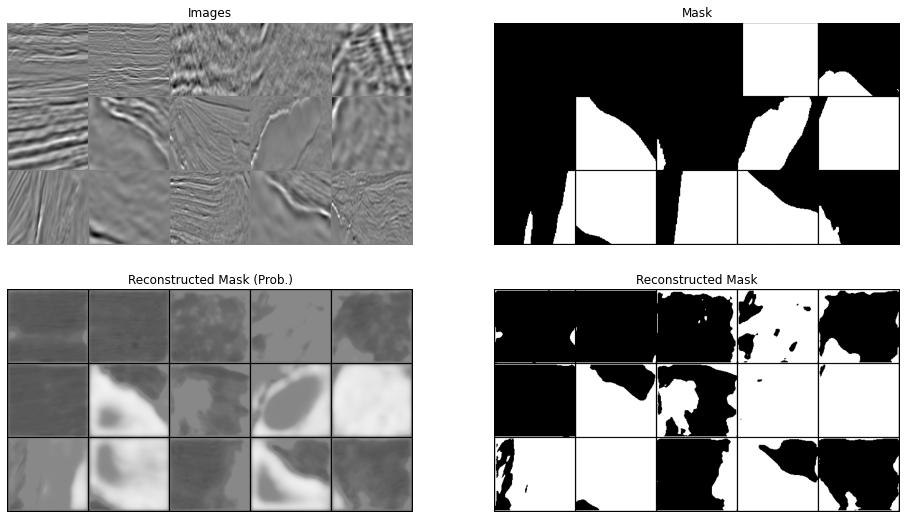

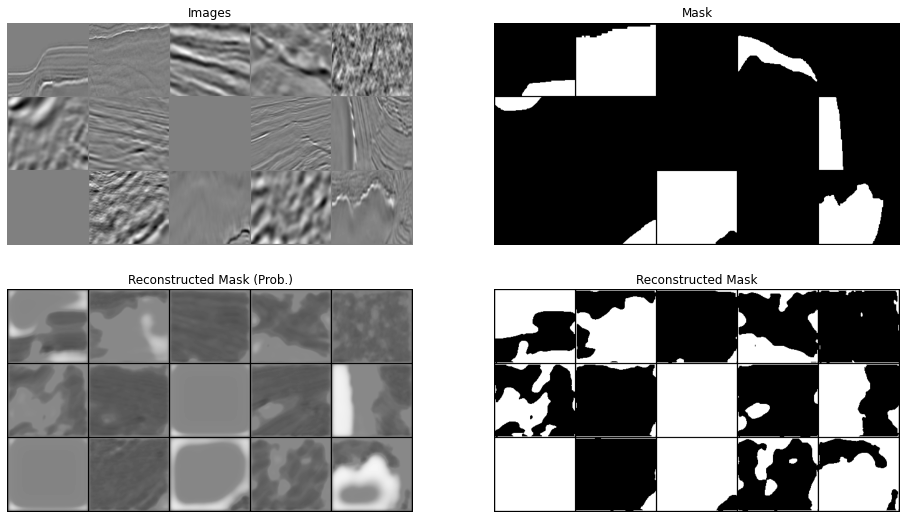

Epoch 0, Training Loss 0.64, Training Accuracy 0.63, Test Loss 0.58, Test Accuracy 0.74


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 1, Training Loss 0.51, Training Accuracy 0.74, Test Loss 0.47, Test Accuracy 0.77


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 2, Training Loss 0.44, Training Accuracy 0.77, Test Loss 0.39, Test Accuracy 0.82


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 3, Training Loss 0.37, Training Accuracy 0.83, Test Loss 0.34, Test Accuracy 0.88


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 4, Training Loss 0.32, Training Accuracy 0.87, Test Loss 0.32, Test Accuracy 0.88


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 5, Training Loss 0.29, Training Accuracy 0.90, Test Loss 0.28, Test Accuracy 0.90


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 6, Training Loss 0.27, Training Accuracy 0.90, Test Loss 0.29, Test Accuracy 0.88


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 7, Training Loss 0.27, Training Accuracy 0.90, Test Loss 0.26, Test Accuracy 0.90


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 8, Training Loss 0.24, Training Accuracy 0.91, Test Loss 0.25, Test Accuracy 0.90


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 9, Training Loss 0.23, Training Accuracy 0.91, Test Loss 0.24, Test Accuracy 0.91


  0%|          | 0/50 [00:00<?, ?it/s]

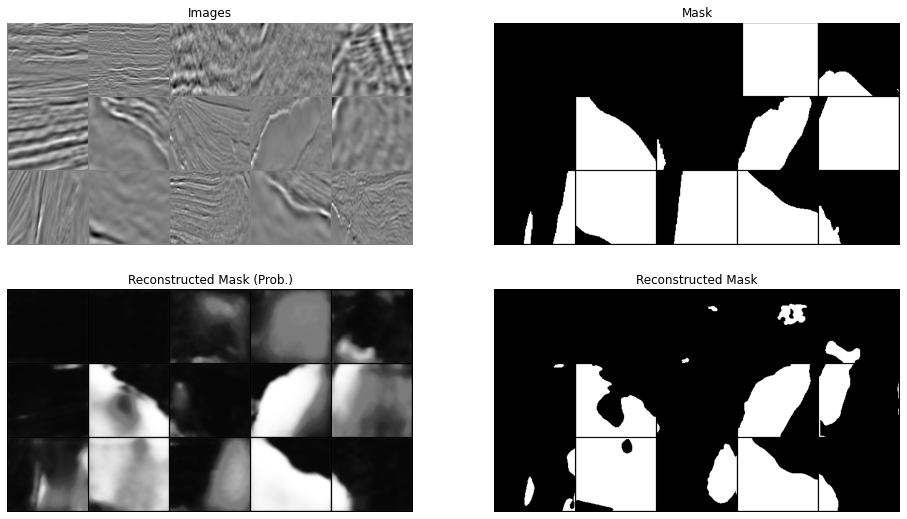

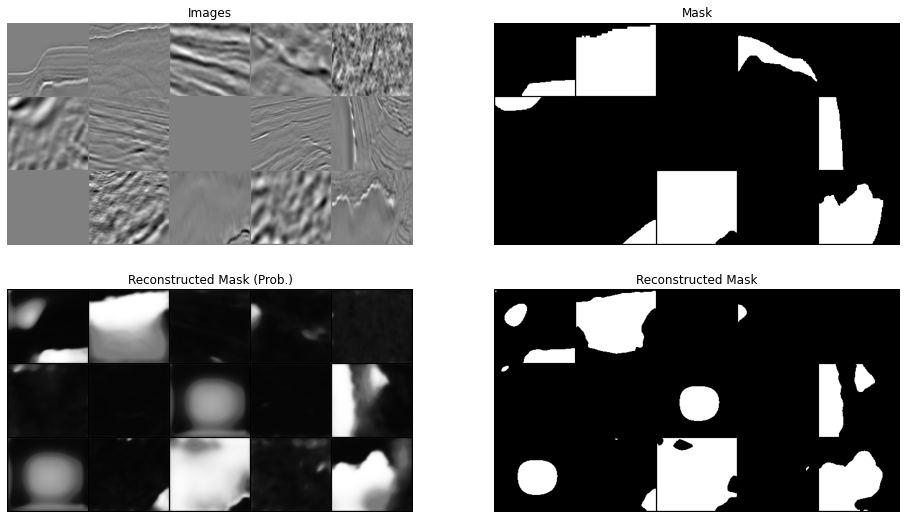

Epoch 10, Training Loss 0.22, Training Accuracy 0.91, Test Loss 0.24, Test Accuracy 0.91


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 11, Training Loss 0.21, Training Accuracy 0.92, Test Loss 0.23, Test Accuracy 0.91


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 12, Training Loss 0.21, Training Accuracy 0.92, Test Loss 0.23, Test Accuracy 0.91


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 13, Training Loss 0.24, Training Accuracy 0.91, Test Loss 0.24, Test Accuracy 0.91


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 14, Training Loss 0.21, Training Accuracy 0.92, Test Loss 0.22, Test Accuracy 0.92


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 15, Training Loss 0.19, Training Accuracy 0.93, Test Loss 0.21, Test Accuracy 0.92


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 16, Training Loss 0.19, Training Accuracy 0.93, Test Loss 0.20, Test Accuracy 0.92


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 17, Training Loss 0.18, Training Accuracy 0.93, Test Loss 0.19, Test Accuracy 0.93


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 18, Training Loss 0.18, Training Accuracy 0.93, Test Loss 0.18, Test Accuracy 0.93


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 19, Training Loss 0.19, Training Accuracy 0.93, Test Loss 0.20, Test Accuracy 0.92


  0%|          | 0/50 [00:00<?, ?it/s]

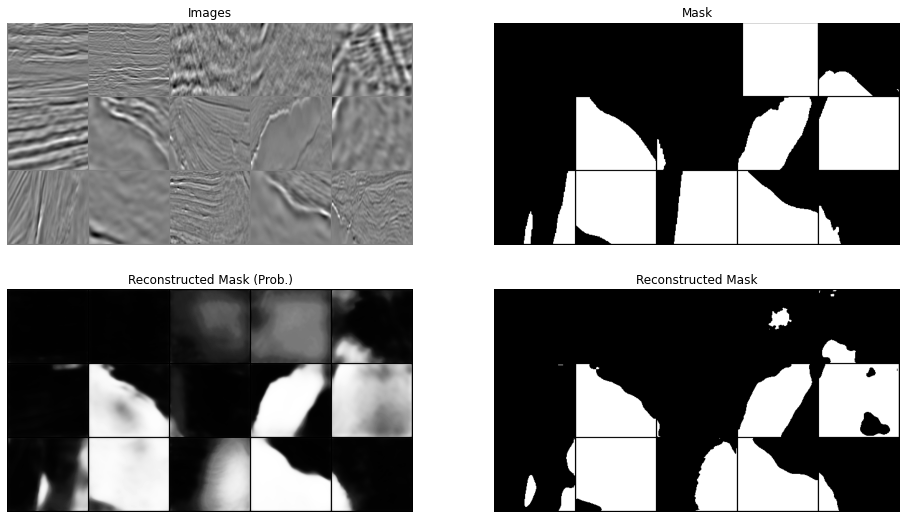

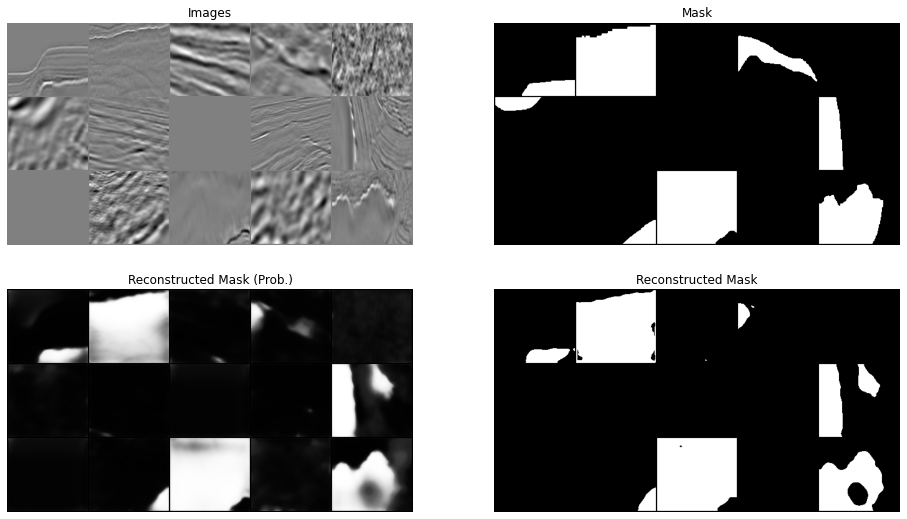

Epoch 20, Training Loss 0.17, Training Accuracy 0.93, Test Loss 0.19, Test Accuracy 0.93


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 21, Training Loss 0.17, Training Accuracy 0.93, Test Loss 0.18, Test Accuracy 0.93


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 22, Training Loss 0.17, Training Accuracy 0.94, Test Loss 0.18, Test Accuracy 0.93


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 23, Training Loss 0.16, Training Accuracy 0.94, Test Loss 0.19, Test Accuracy 0.93


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 24, Training Loss 0.16, Training Accuracy 0.94, Test Loss 0.17, Test Accuracy 0.93


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 25, Training Loss 0.16, Training Accuracy 0.94, Test Loss 0.16, Test Accuracy 0.94


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 26, Training Loss 0.15, Training Accuracy 0.94, Test Loss 0.16, Test Accuracy 0.94


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 27, Training Loss 0.17, Training Accuracy 0.93, Test Loss 0.18, Test Accuracy 0.93


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 28, Training Loss 0.18, Training Accuracy 0.93, Test Loss 0.17, Test Accuracy 0.94


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 29, Training Loss 0.16, Training Accuracy 0.94, Test Loss 0.17, Test Accuracy 0.94


  0%|          | 0/50 [00:00<?, ?it/s]

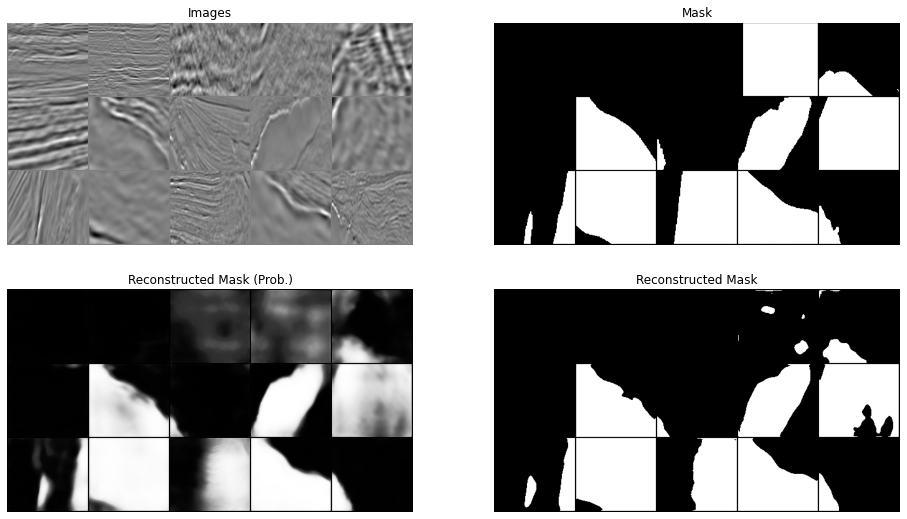

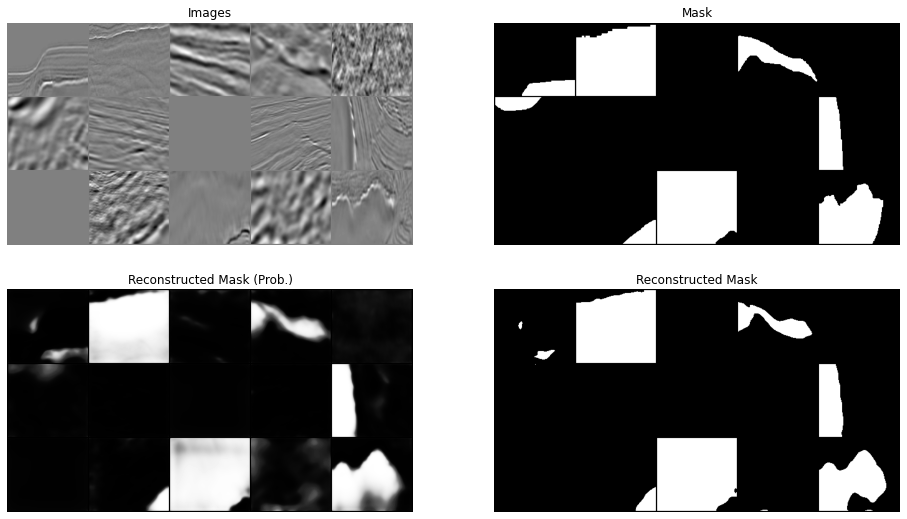

Epoch 30, Training Loss 0.15, Training Accuracy 0.94, Test Loss 0.15, Test Accuracy 0.94


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 31, Training Loss 0.14, Training Accuracy 0.95, Test Loss 0.15, Test Accuracy 0.94


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 32, Training Loss 0.14, Training Accuracy 0.95, Test Loss 0.16, Test Accuracy 0.94


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 33, Training Loss 0.15, Training Accuracy 0.94, Test Loss 0.16, Test Accuracy 0.94


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 34, Training Loss 0.13, Training Accuracy 0.95, Test Loss 0.15, Test Accuracy 0.94


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 35, Training Loss 0.14, Training Accuracy 0.94, Test Loss 0.18, Test Accuracy 0.93


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 36, Training Loss 0.13, Training Accuracy 0.95, Test Loss 0.15, Test Accuracy 0.94


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 37, Training Loss 0.13, Training Accuracy 0.95, Test Loss 0.15, Test Accuracy 0.95


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 38, Training Loss 0.12, Training Accuracy 0.95, Test Loss 0.15, Test Accuracy 0.95


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 39, Training Loss 0.12, Training Accuracy 0.95, Test Loss 0.15, Test Accuracy 0.94


  0%|          | 0/50 [00:00<?, ?it/s]

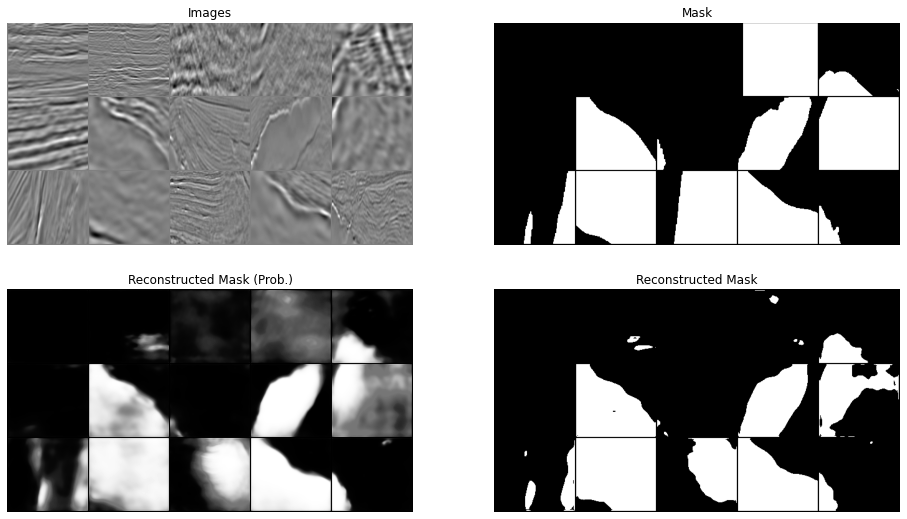

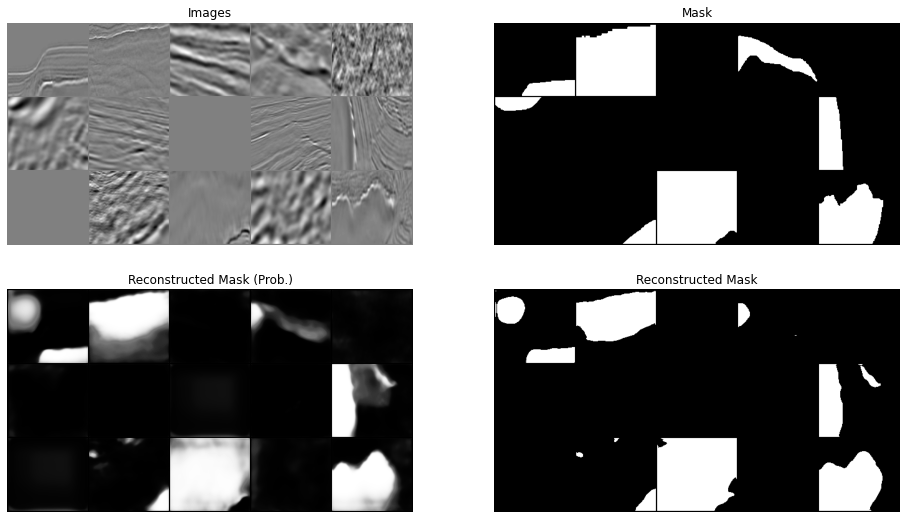

Epoch 40, Training Loss 0.15, Training Accuracy 0.94, Test Loss 0.18, Test Accuracy 0.92


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 41, Training Loss 0.13, Training Accuracy 0.95, Test Loss 0.15, Test Accuracy 0.94


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 42, Training Loss 0.12, Training Accuracy 0.95, Test Loss 0.16, Test Accuracy 0.94


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 43, Training Loss 0.11, Training Accuracy 0.96, Test Loss 0.15, Test Accuracy 0.95


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 44, Training Loss 0.11, Training Accuracy 0.96, Test Loss 0.14, Test Accuracy 0.95


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 45, Training Loss 0.10, Training Accuracy 0.96, Test Loss 0.14, Test Accuracy 0.95


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 46, Training Loss 0.10, Training Accuracy 0.96, Test Loss 0.15, Test Accuracy 0.95


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 47, Training Loss 0.10, Training Accuracy 0.96, Test Loss 0.12, Test Accuracy 0.96


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 48, Training Loss 0.09, Training Accuracy 0.97, Test Loss 0.11, Test Accuracy 0.96


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 49, Training Loss 0.09, Training Accuracy 0.97, Test Loss 0.12, Test Accuracy 0.96


  0%|          | 0/50 [00:00<?, ?it/s]

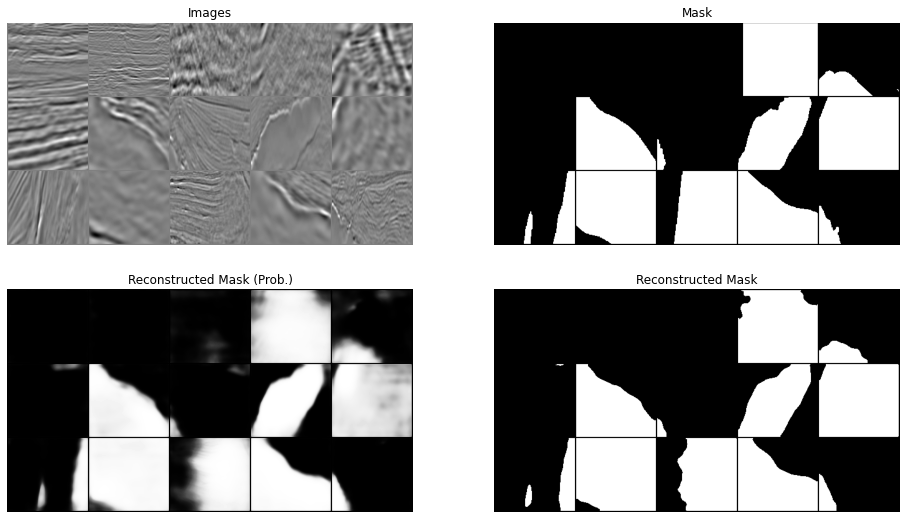

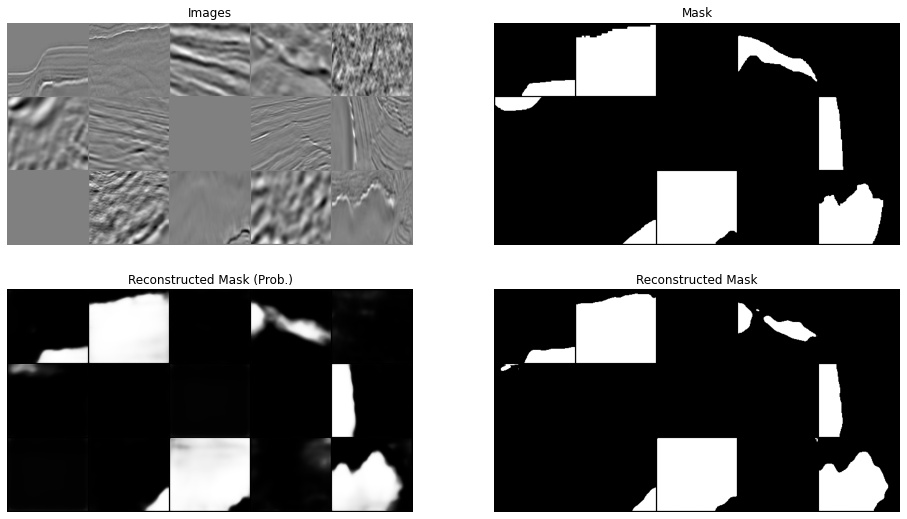

Epoch 50, Training Loss 0.09, Training Accuracy 0.97, Test Loss 0.12, Test Accuracy 0.96


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 51, Training Loss 0.09, Training Accuracy 0.97, Test Loss 0.12, Test Accuracy 0.96


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 52, Training Loss 0.08, Training Accuracy 0.97, Test Loss 0.11, Test Accuracy 0.96


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 53, Training Loss 0.08, Training Accuracy 0.97, Test Loss 0.11, Test Accuracy 0.96


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 54, Training Loss 0.08, Training Accuracy 0.97, Test Loss 0.11, Test Accuracy 0.96


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 55, Training Loss 0.07, Training Accuracy 0.98, Test Loss 0.11, Test Accuracy 0.96


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 56, Training Loss 0.07, Training Accuracy 0.98, Test Loss 0.11, Test Accuracy 0.96


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 57, Training Loss 0.07, Training Accuracy 0.97, Test Loss 0.10, Test Accuracy 0.96


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 58, Training Loss 0.06, Training Accuracy 0.98, Test Loss 0.10, Test Accuracy 0.97


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 59, Training Loss 0.06, Training Accuracy 0.98, Test Loss 0.09, Test Accuracy 0.97


  0%|          | 0/50 [00:00<?, ?it/s]

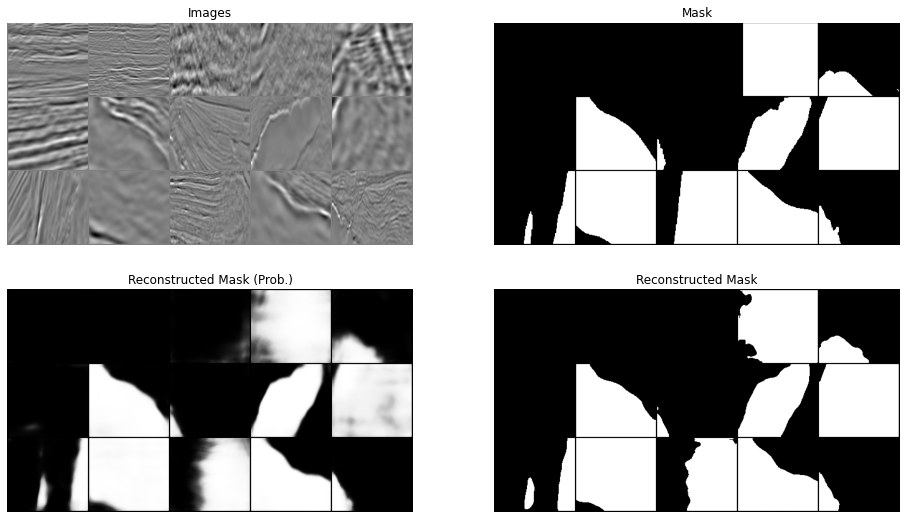

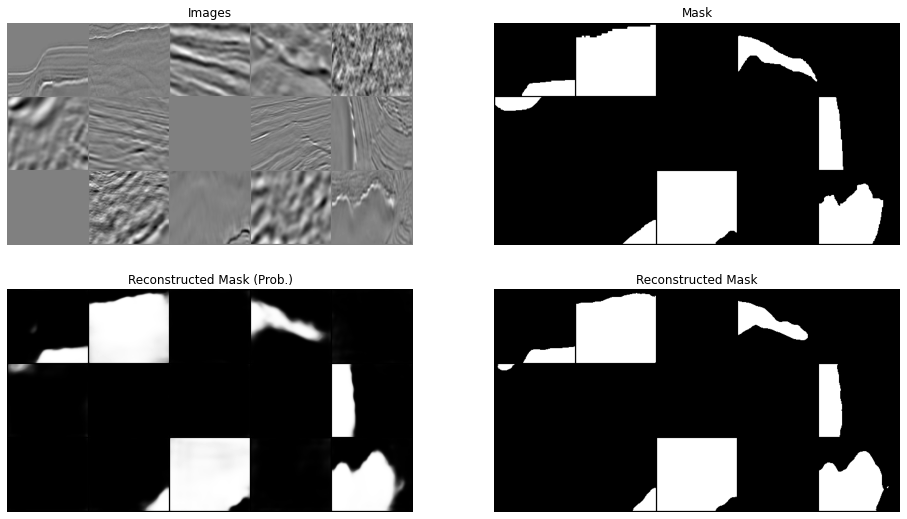

Epoch 60, Training Loss 0.06, Training Accuracy 0.98, Test Loss 0.09, Test Accuracy 0.97


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 61, Training Loss 0.06, Training Accuracy 0.98, Test Loss 0.10, Test Accuracy 0.97


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 62, Training Loss 0.06, Training Accuracy 0.98, Test Loss 0.09, Test Accuracy 0.97


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 63, Training Loss 0.07, Training Accuracy 0.98, Test Loss 0.09, Test Accuracy 0.97


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 64, Training Loss 0.06, Training Accuracy 0.98, Test Loss 0.09, Test Accuracy 0.97


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 65, Training Loss 0.06, Training Accuracy 0.98, Test Loss 0.10, Test Accuracy 0.97


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 66, Training Loss 0.06, Training Accuracy 0.98, Test Loss 0.09, Test Accuracy 0.97


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 67, Training Loss 0.11, Training Accuracy 0.96, Test Loss 0.13, Test Accuracy 0.95


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 68, Training Loss 0.08, Training Accuracy 0.97, Test Loss 0.10, Test Accuracy 0.97


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 69, Training Loss 0.07, Training Accuracy 0.98, Test Loss 0.10, Test Accuracy 0.97


  0%|          | 0/50 [00:00<?, ?it/s]

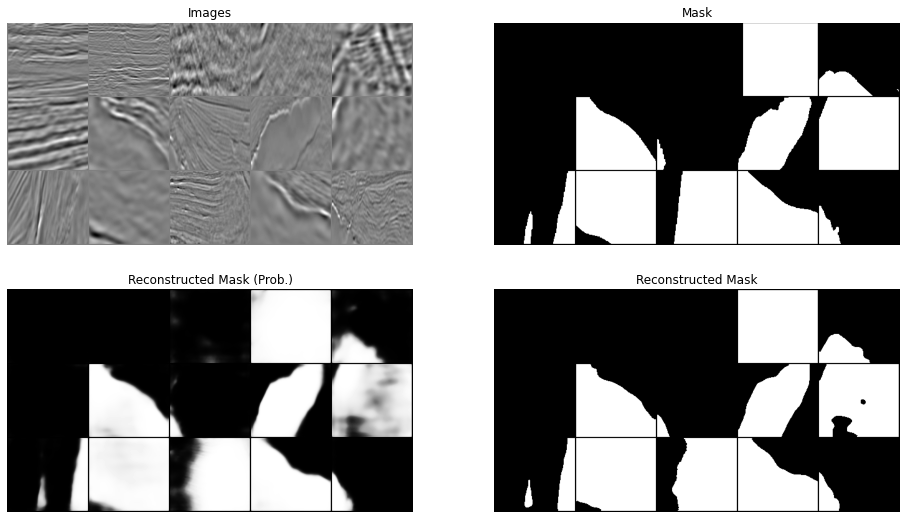

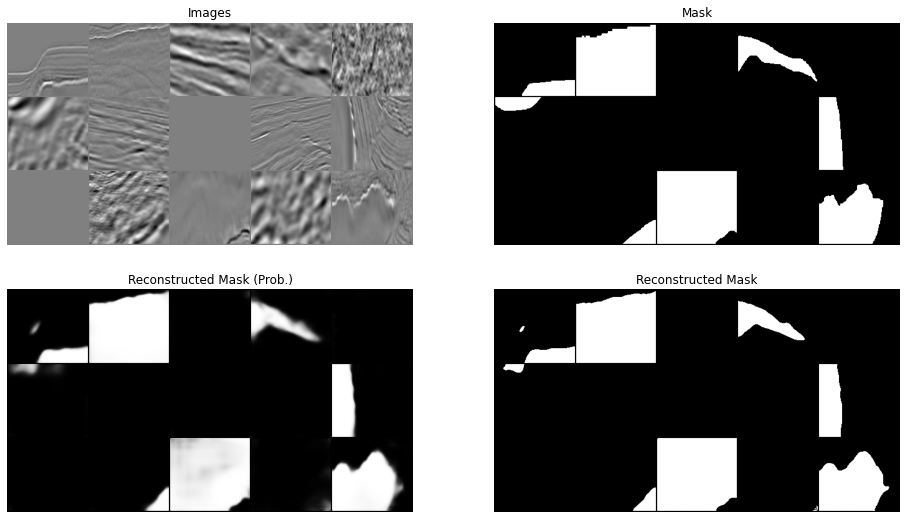

Epoch 70, Training Loss 0.05, Training Accuracy 0.98, Test Loss 0.09, Test Accuracy 0.97


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 71, Training Loss 0.08, Training Accuracy 0.97, Test Loss 0.12, Test Accuracy 0.96


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 72, Training Loss 0.07, Training Accuracy 0.98, Test Loss 0.09, Test Accuracy 0.97


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 73, Training Loss 0.05, Training Accuracy 0.98, Test Loss 0.10, Test Accuracy 0.97


  0%|          | 0/50 [00:00<?, ?it/s]

In [ ]:
n_epochs = 150
lr = 0.001

criterion = nn.BCEWithLogitsLoss()
optim = torch.optim.Adam(network.parameters(), lr=lr)

train_loss_history = np.zeros(n_epochs)
train_accuracy_history = np.zeros(n_epochs)
test_loss_history = np.zeros(n_epochs)
test_accuracy_history = np.zeros(n_epochs)

for i in range(n_epochs):
    train_loss, train_accuracy = train(network, criterion, optim, 
                                       train_loader, device=device, 
                                       plotflag=True if i%10==0 else False)
    test_loss, test_accuracy = evaluate(network, criterion, 
                                        valid_loader, device=device, 
                                        plotflag=True if i%10==0 else False)
    train_loss_history[i], train_accuracy_history[i] = train_loss, train_accuracy
    test_loss_history[i], test_accuracy_history[i] = test_loss, test_accuracy
    print(f'Epoch {i}, Training Loss {train_loss:.2f}, Training Accuracy {train_accuracy:.2f}, Test Loss {test_loss:.2f}, Test Accuracy {test_accuracy:.2f}')
    torch.save(network.state_dict(), './models_saltNET_level4/model_%03d.pth' % i)

In [ ]:
plt.figure()
plt.plot(train_loss_history, 'k', label='Train')
plt.plot(test_loss_history, 'r', label='Valid')
plt.title('Loss history')
plt.legend()

plt.figure()
plt.plot(train_accuracy_history, 'k', label='Train')
plt.plot(test_accuracy_history, 'r', label='Valid')
plt.title('Accuracy history')
plt.legend();

print('Valid Accuracy (best)', test_accuracy_history.max())

## Prediction

Let's now display our predictions for a couple of batches

In [ ]:
# dl = next(iter(train_loader)) # nextbatch 
i = 0
for dl in train_loader:
    predict(network,  dl['image'], dl['mask'], device=device)
    i+=1
    if i == 4:
        break

All in all our results aren't too bad. We have however just scratched the surface. You can continue from here with your experimentation and try to see if making small changes can improve your results. This may be:

- better loss term: we have used the basic BCE loss function here even though we saw earlier that the 0s and 1s are not balanced in our training data. Can you make a change to the loss to account for that? Moreover the literature of image segmentation is very vast and lots of work has been done with respect to the loss function, see for example https://www.jeremyjordan.me/semantic-segmentation/#loss

- data augumentation and cleaning: we mentioned already this when looking at the training data. If you look at the second image in the prediction you will see that this does not really look like a salt body (or at least not the entire data patch, but the label seems to suggest so, why so? Whilst it may sound more fun to play with different architectures, it is well known in the ML community that improving the quality and variety of our data may have a much more striking impact on our model performance than anything else. See for example Andrew Ng campaign on data centric AI (https://www.forbes.com/sites/gilpress/2021/06/16/andrew-ng-launches-a-campaign-for-data-centric-ai/). Try to look at your data and see if you can spot obvious mistakes, both by eyes and perhaps using simple automated techinques (or ML too!)

- architectures: you can also find other popular architetures used for image segmentation and compare their performance with our UNet. We will soon learn more about one of the most popular architectures for sequence modelling (e.g., language processing) called Transformer. Recently, the computer vision community has realized that such a type of NNs could outperfrom CNNs in image tasks. Why not looking into this (e.g., https://github.com/NVlabs/SegFormer), it may be a good project for some of you